## Imports

In [139]:
import logging
import os
import random
import sys
from collections import deque
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym
import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from src.actor_critic import ContinuousActorCritic
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.vae import VAE
from src.imagination_env import ImaginationEnv
from src.mlp import MLP
from src.preprocessing import grayscale_transform as transform
from src.replay_buffer import ReplayBuffer
from src.rssm import RSSM
from src.utils import (load_config, make_env, save_image_and_reconstruction,
                       to_np)
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

torch.cuda.empty_cache()
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load the config
config = load_config()
for key in config:
    locals()[key] = config[key]

## Load the config

In [2]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 2, 'Z': 1024, 'debug': False, 'show_inline_tensorboard': False, 'log_dir': 'logs/', 'seed': 0, 'exe_path': '/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64', 'env_id': 'donkey-minimonaco-track-v0', 'port': 9091, 'frame_skip': 2, 'max_cte': 4.0, 'body_style': 'f1', 'body_rgb': [255, 255, 255], 'car_name': 'RL-Racer', 'font_size': 30, 'toy_env': False, 'vectorized': True, 'n_envs': 2, 'size': [64, 64], 'grayscale': False, 'start_episode': 1000, 'n_seed_episodes': 1000, 'n_training_episodes': 5000, 'max_episode_steps': 1000, 'max_imagination_episode_steps': 15, 'imagination_timesteps_per_model_update': 200, 'max_grad_norm': 1, 'rssm_lr': 0.0001, 'rssm_l2_regularization': 1e-06, 'batch_size': 1, 'H': 512, 'uniform_ratio': 0.01, 'buffer_size': 50000, 'activation': 'silu', 'num_categoricals': 32, 'num_classes': 32, 'channels': [64, 128, 256, 512, 256], 'kernel_size': 3, 'stride': 2, 'padding': 1, 'conv_bias': False, 'entr

## Create the environment

In [ ]:
env = make_env()

## Train an agent

In [ ]:
train_agent = False

if train_agent:
    
    agent = PPO(
        "CnnPolicy",
        env,
        verbose=1,
        tensorboard_log="baseline_logs/"
    )
    agent.learn(total_timesteps=500_000)

In [ ]:
save_agent = False

if save_agent:
    # agent.save("baseline_weights/SAC_500k")
    # agent.save_replay_buffer("baseline_weights/SAC_500k_replay_buffer")
    
    agent.save("baseline_weights/AGENTNAMEHERE")

In [ ]:
load_agent = False

if load_agent:
    
    # create the agent
    eval_agent = A2C(
        "CnnPolicy", 
        env,
        #buffer_size=0,
        verbose=1, 
        # tensorboard_log="baseline_logs/"
    )
    
    # load the agent
    eval_agent.load("baseline_weights/A2C_500k")
    # eval_agent.load_replay_buffer("baseline_weights/SAC_500k_replay_buffer")

## Trained Policy Evaluation

In [6]:
evaluate_trained_policy = False

if evaluate_trained_policy:

    env = make_env()

    eval_agent = PPO(
        "CnnPolicy", 
        env,
        # buffer_size=0,
        verbose=1, 
    )
    eval_agent.load("baseline_weights/PPO-500k-2Agents.zip")

    policy = eval_agent.policy
    episode_rewards, episode_lengths = evaluate_policy(policy, env, n_eval_episodes=30, deterministic=True, return_episode_rewards=True)
    env.close()

In [7]:
evaluate_trained_policy = False

if evaluate_trained_policy:
    n_trials = 30

    env = make_env()

    eval_agent = PPO(
        "CnnPolicy", 
        env,
        # buffer_size=0,
        verbose=1, 
    )
    eval_agent.load("baseline_weights/PPO-500k-2Agents.zip")

    episode_rewards = []
    episode_lengths = []

    for i in range(n_trials):
        print("Starting eval episode", i)
        episode_reward = 0.0
        episode_length = 0

        obs, info = env.reset()
        done = False
        while not done:
            action = eval_agent.predict(obs, deterministic=False)
            if isinstance(action, tuple):
                action = action[0]
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_length += 1
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    # episode_rewards, episode_lengths = evaluate_policy(eval_agent, env, n_eval_episodes=30, return_episode_rewards=True, deterministic=True)
    print(f"mean_reward={np.mean(episode_rewards):.3f} +/- {np.std(episode_rewards):.3f}")
    print(f"mean_length={np.mean(episode_lengths):.3f} +/- {np.std(episode_lengths):.3f}")
    

In [ ]:
save_files = False

if save_files:

    with open("baseline_eval/PPO-500k-2Agents_episode_rewards.npy", 'wb') as f:
        np.save(f, episode_rewards)

    with open("baseline_eval/PPO-500k-2Agents_episode_lengths.npy", 'wb') as f:
        np.save(f, episode_lengths)

In [ ]:
# eval_rewards, eval_lengths = evaluate_policy(eval_agent, env, n_eval_episodes=100, return_episode_rewards=True, deterministic=True)

In [ ]:
# np.save("eval_rewards", np.array(eval_rewards))
# np.save("eval_lengths", np.array(eval_lengths))

In [ ]:
# agent = SAC(
#     "CnnPolicy", 
#     env,
#     buffer_size=20_000,
#     verbose=1, 
#     tensorboard_log="logs/")
# 
# eval_callback = EvalCallback(
#     env, 
#     best_model_save_path='weights/', 
#     log_path='logs/', 
#     eval_freq=500,
#     n_eval_episodes=1)
#
# agent.learn(total_timesteps=30_000, callback=eval_callback)

## Load the training metrics into dataframes

In [63]:
metrics = [
    "rollout/ep_rew_mean",     # SAC: ✅, PPO: ✅, A2C: ✅
    "rollout/ep_len_mean",     # SAC: ✅, PPO: ✅, A2C: ✅
    "train/critic_loss",       # SAC: critic_loss, PPO: value_loss, A2C: value_loss
    "train/actor_loss",        # SAC: actor_loss, PPO: policy_gradient_loss, A2C: policy_loss
    "train/entropy_loss",     # SAC: ent_coef_loss, PPO: entropy_loss, A2C: entropy_loss
    "time/fps" # SAC: ✅, PPO: ✅, A2C: ✅
]

baselines = {
    "A2C_500k": "baseline_logs/A2C_500k/events.out.tfevents.1685255857.z.54420.0",
    "SAC_500k": "baseline_logs/SAC_500k/events.out.tfevents.1685211019.z.35749.0",
    "PPO (1 Agent)_500k": "baseline_logs/PPO_500k/events.out.tfevents.1685229886.z.44451.0",
    "PPO (2 Agents)_500k": "baseline_logs/PPO_500k_2Agents/events.out.tfevents.1685751361.z.43203.0",
}

dataframes = {}

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    rows = []
    for metric in metrics:
        
        if metric == "train/critic_loss":
            if "PPO" in key or "A2C" in key:
                metric = "train/value_loss"
        
        if metric == "train/actor_loss":
            if "PPO" in key:
                metric = "train/policy_gradient_loss"
            elif "A2C" in key:
                metric = "train/policy_loss"
        
        if metric == "train/entropy_loss":
            if "SAC" in key:
                metric = "train/ent_coef_loss"        
        
        steps = []
        values = []
        for event in event_acc.Scalars(metric):
            steps.append(event.step)
            values.append(event.value)
        rows.append(values)

    df = pd.DataFrame(rows, columns=steps, index=metrics)
    dataframes[key] = df

print("Created dataframes:", list(dataframes.keys()))
    
sac_500k_df = dataframes["SAC_500k"].T
ppo_500k_df = dataframes["PPO (1 Agent)_500k"].T
a2c_500k_df = dataframes["A2C_500k"].T
ppo_500k_2agents_df = dataframes["PPO (2 Agents)_500k"].T

Created dataframes: ['A2C_500k', 'SAC_500k', 'PPO (1 Agent)_500k', 'PPO (2 Agents)_500k']


In [37]:
#sac_500k_df.describe()
#ppo_500k_df.describe()
#a2c_500k_df.describe()
#ppo_500k_2agents_df.describe()

## Save last 30 trials

In [170]:
save_files = False

if save_files:
    
    # Change these variables:
    algo_df = sac_500k_df.copy()
    algo_name = "sac_500k"
    
    # Don't change this.
    episode_rewards = list(algo_df["rollout/ep_rew_mean"][-30:])
    episode_lengths = list(algo_df["rollout/ep_len_mean"][-30:])
    
    with open(f"baseline_eval/{algo_name}_episode_rewards.npy", 'wb') as f:
        np.save(f, episode_rewards)

    with open(f"baseline_eval/{algo_name}_episode_lengths.npy", 'wb') as f:
        np.save(f, episode_lengths)

## Plot the episode reward and length

In [68]:
os.listdir("baseline_eval")

['RANDOM_AGENT_episode_lengths.npy',
 'sac_500k_episode_rewards.npy',
 'ppo_500k_2agents_episode_rewards.npy',
 'a2c_500k_episode_rewards.npy',
 'a2c_500k_episode_lengths.npy',
 'ppo_500k_episode_lengths.npy',
 'ppo_500k_2agents_episode_lengths.npy',
 'ppo_500k_episode_rewards.npy',
 'RANDOM_AGENT_episode_rewards.npy',
 'sac_500k_episode_lengths.npy']

In [113]:
data["PPO (1 Agent)"]["episode_lengths"].mean()

111.1523333231608

In [209]:
data = {
    "Random Agent": {
        "episode_rewards": np.load("baseline_eval/RANDOM_AGENT_episode_rewards.npy"),
        "episode_lengths": np.load("baseline_eval/RANDOM_AGENT_episode_lengths.npy"),
    },
    
    "A2C": {
        "episode_rewards": np.load("baseline_eval/a2c_500k_episode_rewards.npy"),
        "episode_lengths": np.load("baseline_eval/a2c_500k_episode_lengths.npy"), 
    },
    
    "PPO (2 Agents)": {
        "episode_rewards": np.load("baseline_eval/ppo_500k_2agents_episode_rewards.npy"),
        "episode_lengths": np.load("baseline_eval/ppo_500k_2agents_episode_lengths.npy"), 
    },
    
    "SAC": {
        "episode_rewards": np.load("baseline_eval/sac_500k_episode_rewards.npy"),
        "episode_lengths": np.load("baseline_eval/sac_500k_episode_lengths.npy"), 
    },
    
    "PPO (1 Agent)": {
        "episode_rewards": np.load("baseline_eval/ppo_500k_episode_rewards.npy"),
        "episode_lengths": np.load("baseline_eval/ppo_500k_episode_lengths.npy"), 
    },
    
}

In [210]:
for key in data.keys():
    print("---", key, "---")
    
    episode_rewards = data[key]["episode_rewards"]
    episode_lengths = data[key]["episode_lengths"]
    
    print(f"Episode reward: {np.mean(episode_rewards):.3f} $\pm$ {np.std(episode_rewards):.3f}")
    print(f"Episode length: {np.mean(episode_lengths):.3f} $\pm$ {np.std(episode_lengths):.3f}")
    print()

--- Random Agent ---
Episode reward: 1.757 $\pm$ 0.766
Episode length: 11.500 $\pm$ 2.125

--- A2C ---
Episode reward: 14.809 $\pm$ 0.110
Episode length: 22.219 $\pm$ 0.089

--- PPO (2 Agents) ---
Episode reward: 108.304 $\pm$ 14.118
Episode length: 112.099 $\pm$ 10.227

--- SAC ---
Episode reward: 187.888 $\pm$ 59.434
Episode length: 185.477 $\pm$ 51.467

--- PPO (1 Agent) ---
Episode reward: 252.929 $\pm$ 19.450
Episode length: 111.152 $\pm$ 6.732



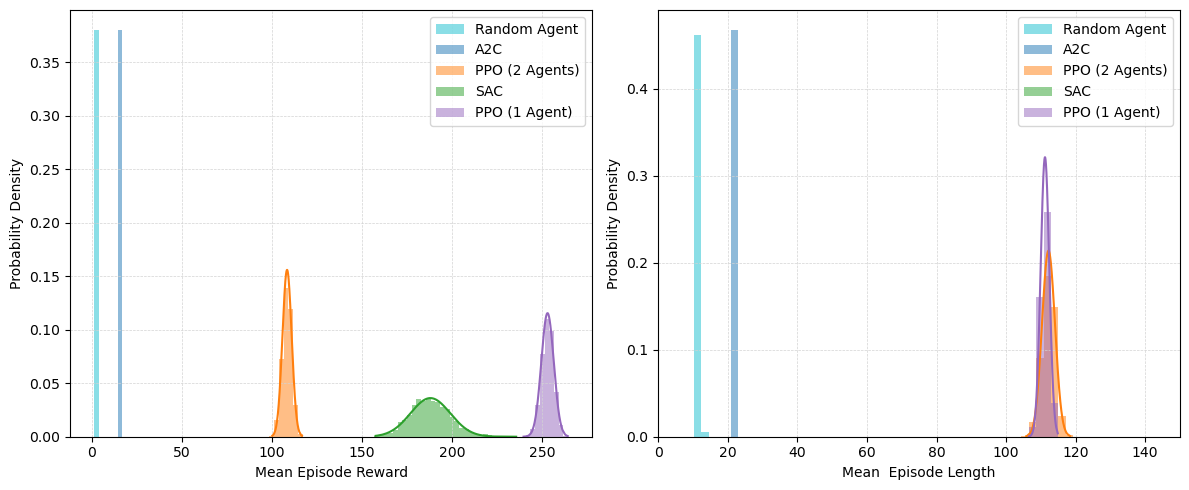

In [212]:
num_bootstrap_samples = 2000
num_bins = 100

colors = ["tab:cyan", "tab:blue", "tab:orange", "tab:green", "tab:purple"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Calculate common bin edges for all distributions
all_bootstrap_rewards = []
all_bootstrap_lengths = []

for key in data.keys():
    episode_rewards = data[key]["episode_rewards"]
    episode_lengths = data[key]["episode_lengths"]

    bootstrap_rewards = []
    bootstrap_lengths = []

    for _ in range(num_bootstrap_samples):
        # bootstrap sampling for episode rewards
        bootstrap_rewards_sample = np.random.choice(episode_rewards, size=len(episode_rewards), replace=True)
        bootstrap_rewards.append(np.mean(bootstrap_rewards_sample))

        # bootstrap sampling for episode lengths
        bootstrap_lengths_sample = np.random.choice(episode_lengths, size=len(episode_lengths), replace=True)
        bootstrap_lengths.append(np.mean(bootstrap_lengths_sample))

    all_bootstrap_rewards.extend(bootstrap_rewards)
    all_bootstrap_lengths.extend(bootstrap_lengths)

# Calculate common bin edges
reward_min = np.min(all_bootstrap_rewards)
reward_max = np.max(all_bootstrap_rewards)
length_min = np.min(all_bootstrap_lengths)
length_max = np.max(all_bootstrap_lengths)

# bins = np.linspace(min(reward_min, length_min), max(reward_max, length_max), num_bins)

for key_idx, key in enumerate(data.keys()):
    episode_rewards = data[key]["episode_rewards"]
    episode_lengths = data[key]["episode_lengths"]

    bootstrap_rewards = []
    bootstrap_lengths = []

    for _ in range(num_bootstrap_samples):
        # bootstrap sampling for episode rewards
        bootstrap_rewards_sample = np.random.choice(episode_rewards, size=len(episode_rewards), replace=True)
        bootstrap_rewards.append(np.mean(bootstrap_rewards_sample))

        # bootstrap sampling for episode lengths
        bootstrap_lengths_sample = np.random.choice(episode_lengths, size=len(episode_lengths), replace=True)
        bootstrap_lengths.append(np.mean(bootstrap_lengths_sample))

    # Plot histogram for bootstrapped episode rewards
    axs[0].hist(bootstrap_rewards, bins=num_bins, range=(reward_min, reward_max), alpha=0.5, label=key, density=True, color=colors[key_idx])

    # fit Gaussian distribution to bootstrapped episode rewards
    if key not in ["Random Agent", "A2C"]:
        xs = np.sort(bootstrap_rewards)
        mu_rewards, std_rewards = norm.fit(xs)
        rewards_curve = norm.pdf(xs, mu_rewards, std_rewards)
        axs[0].plot(xs, rewards_curve, color=colors[key_idx])
    
    # Plot histogram for bootstrapped episode lengths
    axs[1].hist(bootstrap_lengths, bins=num_bins, range=(length_min, length_max), alpha=0.5, label=key, density=True, color=colors[key_idx])

    # fit Gaussian distribution to bootstrapped episode lengths
    if key not in ["Random Agent", "A2C"]:
        xs = np.sort(bootstrap_lengths)
        mu_rewards, std_rewards = norm.fit(xs)
        rewards_curve = norm.pdf(xs, mu_rewards, std_rewards)
        axs[1].plot(xs, rewards_curve, color=colors[key_idx])
    
# Add labels and legend
axs[0].set_xlabel("Mean Episode Reward")
axs[0].set_ylabel("Probability Density")
#axs[0].set_title("Bootstrapped Episode Rewards")
axs[0].legend()

axs[1].set_xlim(0, 150)
axs[1].set_xlabel("Mean  Episode Length")
axs[1].set_ylabel("Probability Density")
#axs[1].set_title("Bootstrapped Episode Lengths")
axs[1].legend()

for ax in axs:
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

# Show the plot
plt.tight_layout()
plt.savefig("figs/Bootstraped Episode Rewards and Lengths in one plot.pdf")
plt.show()

## Plot the training curves

In [64]:
for key, df in dataframes.items():
    print(key)

A2C_500k
SAC_500k
PPO (1 Agent)_500k
PPO (2 Agents)_500k


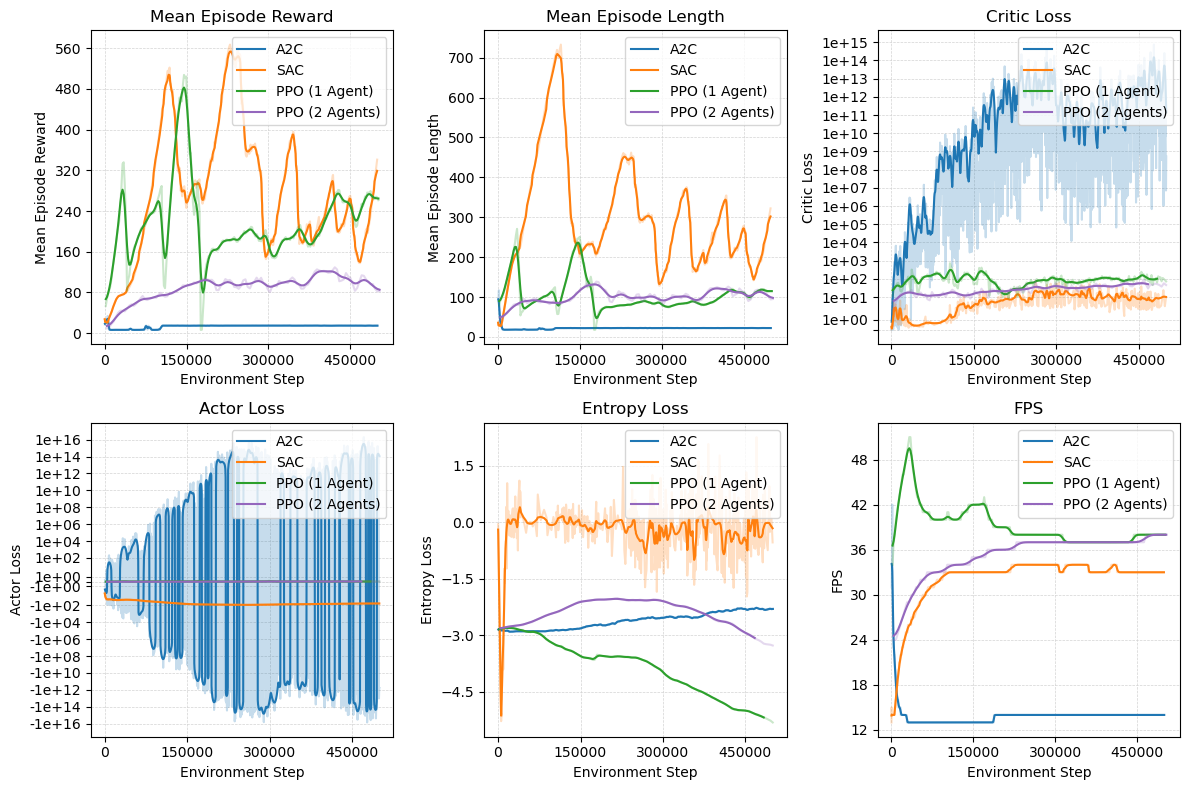

In [56]:
title_dict = {
    "rollout/ep_rew_mean": "Mean Episode Reward",
    "rollout/ep_len_mean": "Mean Episode Length",
    "train/critic_loss": "Critic Loss",
    "train/actor_loss": "Actor Loss",
    "train/entropy_loss": "Entropy Loss",
    "time/fps": "FPS",
}

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# fig.suptitle("Training Metrics with a CNN Policy", fontsize=14)

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    ax.set_title(title_dict[metric])
    ax.set_ylabel(title_dict[metric])
    ax.set_xlabel('Environment Step')

    for j, (key, df) in enumerate(dataframes.items()):
        steps = df.columns
        values = df.loc[metric]
        
        label = key.split("_")[0] # cut of everything after the first underscore
        
        if "actor_loss" in metric and "A2C" in key:
            smoothed_values = gaussian_filter1d(values, sigma=4) 
        else:
            smoothed_values = gaussian_filter1d(values, sigma=2)
        
        ax.plot(steps, smoothed_values, label=label, alpha=1.0, color=colors[j % len(colors)])
        ax.plot(steps, values, alpha=0.25, color=colors[j % len(colors)])
        
        ax.legend(loc="upper right")

    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))

    if "critic_loss" in metric or "actor_loss" in metric:
        ax.set_yscale("symlog")
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.0e}".format(x) if x != 0 else None))
        
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
    ax.set_facecolor('white')

plt.tight_layout()
plt.savefig("figs/Training Metrics with a CNN Policy.pdf")  
plt.show()

## Plot the Explained Variance for A2C

In [214]:
metrics = [
    "train/explained_variance", # A2C
]

baselines = {
    "A2C_500k": "baseline_logs/A2C_500k/events.out.tfevents.1685255857.z.54420.0",
}

dataframes = {}

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    rows = []
    for metric in metrics:
        
        steps = []
        values = []
        for event in event_acc.Scalars(metric):
            steps.append(event.step)
            values.append(event.value)
        rows.append(values)

    df = pd.DataFrame(rows, columns=steps, index=metrics)
    dataframes[key] = df

print("Created dataframes:", list(dataframes.keys()))

explvar_a2c_500k_df = dataframes["A2C_500k"].T

Created dataframes: ['A2C_500k']


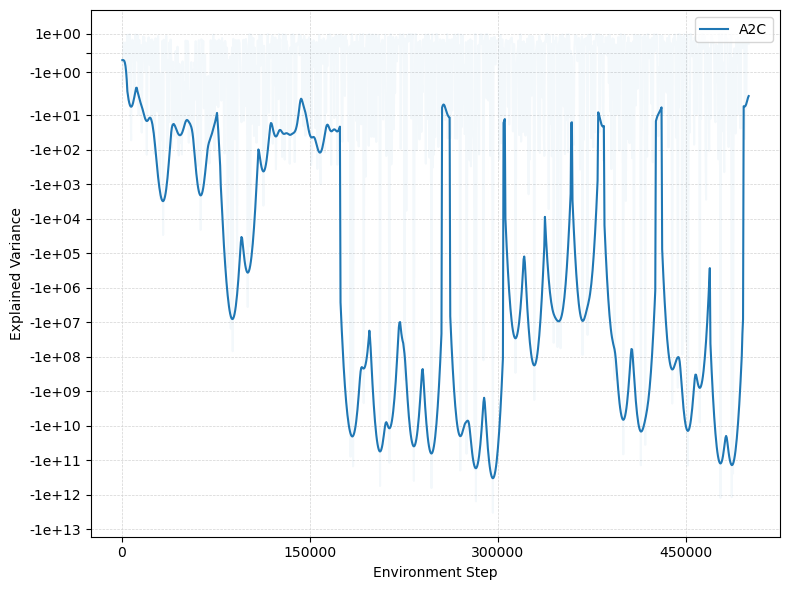

In [222]:
title_dict = {
    "train/explained_variance": "Explained Variance"
}

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

colors = ["tab:blue", "tab:orange", "tab:green"]

metric = "train/explained_variance"
ax = axs

# ax.set_title(title_dict[metric])
ax.set_ylabel(title_dict[metric])
ax.set_xlabel('Environment Step')

for j, (key, df) in enumerate(dataframes.items()):
    steps = df.columns
    values = df.loc[metric]

    label = key.split("_")[0]  # Cut off everything after the first underscore

    if "A2C" in key:
        smoothed_values = gaussian_filter1d(values, sigma=4)

    ax.plot(steps, smoothed_values, label=label, alpha=1.0, color=colors[j % len(colors)])
    ax.plot(steps, values, alpha=0.05, color=colors[j % len(colors)])

    ax.legend(loc="upper right")

ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))

ax.set_yscale("symlog")
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0e}'.format(x) if x != 0 else None))

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
ax.set_facecolor('white')

plt.tight_layout()
plt.savefig("figs/Explained Variance of A2C.pdf")
plt.show()
